# Государственные деньги у НКО

**Задача** — проверить, есть ли зависимость вероятности получения грантов от государства / госконтрактов для некоммерческих организаций:

- от региона регистрации организации;
- возраста организации;
- экономической деятельности организации.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
data = pd.read_csv('data/ngo_data.csv')

data.head()

,ngo_age,has_grant_contract,Деятельность в области спорта прочая,Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе,Аренда и управление собственным или арендованным недвижимым имуществом,"Деятельность по дополнительному профессиональному образованию прочая, не включенная в другие группировки","Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",Строительство жилых и нежилых зданий,Консультирование по вопросам коммерческой деятельности и управления,"Деятельность зрелищно-развлекательная прочая, не включенная в другие группировки",...,regionName_Удмуртская республика,regionName_Ульяновская область,regionName_Хабаровский край,regionName_Ханты-Мансийский автономный округ - Югра,regionName_Челябинская область,regionName_Чеченская республика,regionName_Чувашская республика,regionName_Чукотский автономный округ,regionName_Ямало-Ненецкий автономный округ,regionName_Ярославская область
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Выясним является ли выборка сбалансированной.
mask_min = data['has_grant_contract'] > 0
ratio = round(data[mask_min].shape[0] / data.shape[0] * 100, 2)
print(f'{ratio}% записей имеют значение целевой переменной отличное от 0 класса.')

4.83% записей имеют значение целевой переменной отличное от 0 класса.


In [4]:
data['has_grant_contract'].value_counts()

0    1191163
2      47799
1      11700
3       1013
Name: has_grant_contract, dtype: int64

На основании изложенного видим, что в целевой переменной присутствует дисбаланс классов. Для приведения выборки к сбалансированному виду проведем случайный андерсэмплинг класса 0.

In [5]:
mask_maj = data['has_grant_contract'] == 0
data_sample = pd.concat(
    [
        data[mask_maj].sample(data[mask_min].shape[0]),
        data[mask_min]
    ],
    ignore_index=True
)

data_sample['has_grant_contract'].value_counts()

0    60512
2    47799
1    11700
3     1013
Name: has_grant_contract, dtype: int64

In [6]:
X = data_sample.drop(['has_grant_contract'], axis=1)
y = data_sample[['has_grant_contract']]

# Разделяем выборку на тестовую и обучающую.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print('Размер обучающей выборки:', X_train.shape[0])
print('Размер тестовой выборки:', X_test.shape[0])

Размер обучающей выборки: 96819
Размер тестовой выборки: 24205


In [7]:
# Определим значение F1-метрики для случая случайного угадывания.
y_test_pred_rand = np.array([i % 4 for i in range(y_test.shape[0])])

print('F1 случайное угадывание:', f1_score(y_test, y_test_pred_rand, average='macro').round(3))

F1 случайное угадывание: 0.198


Построим baseline, для данной цели будем использовать мультиклассовую модель логистической регрессии с параметрами по умолчанию. Качество модели будем оценивать с помощью F1-метрики, так как данная метрика нечуствительны к дисбалансу выборки.

In [8]:
# Создадим объект класса логистическая регрессия.
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', 
    class_weight='balanced',
    random_state=42
)

# Обучаем модель.
log_reg.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_log_reg = log_reg.predict(X_test)
y_train_pred_log_reg = log_reg.predict(X_train)

print('F1 логистическая регрессия (train):', f1_score(y_train, y_train_pred_log_reg, average='macro').round(3))
print('F1 логистическая регрессия (test):', f1_score(y_test, y_test_pred_log_reg, average='macro').round(3))

F1 логистическая регрессия (train): 0.418
F1 логистическая регрессия (test): 0.41


In [9]:
# Создадим объект класса решающее дерево.
dec_tr = tree.DecisionTreeClassifier( 
    class_weight='balanced',
    random_state=42
)

# Обучаем модель.
dec_tr.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_dec_tr = dec_tr.predict(X_test)
y_train_pred_dec_tr = dec_tr.predict(X_train)

print('F1 решающие деревья (train):', f1_score(y_train, y_train_pred_dec_tr, average='macro').round(3))
print('F1 решающие деревья (test):', f1_score(y_test, y_test_pred_dec_tr, average='macro').round(3))

F1 решающие деревья (train): 0.84
F1 решающие деревья (test): 0.459


На основании результатов обучения моделей логистическая регрессия и решающие деревья, видим, что алгоритм классификации на основании решаущих деревей переобучается. Подберем оптимальную глубину дерева, и обучим модель с ограниченной глубиной дерева решений. 

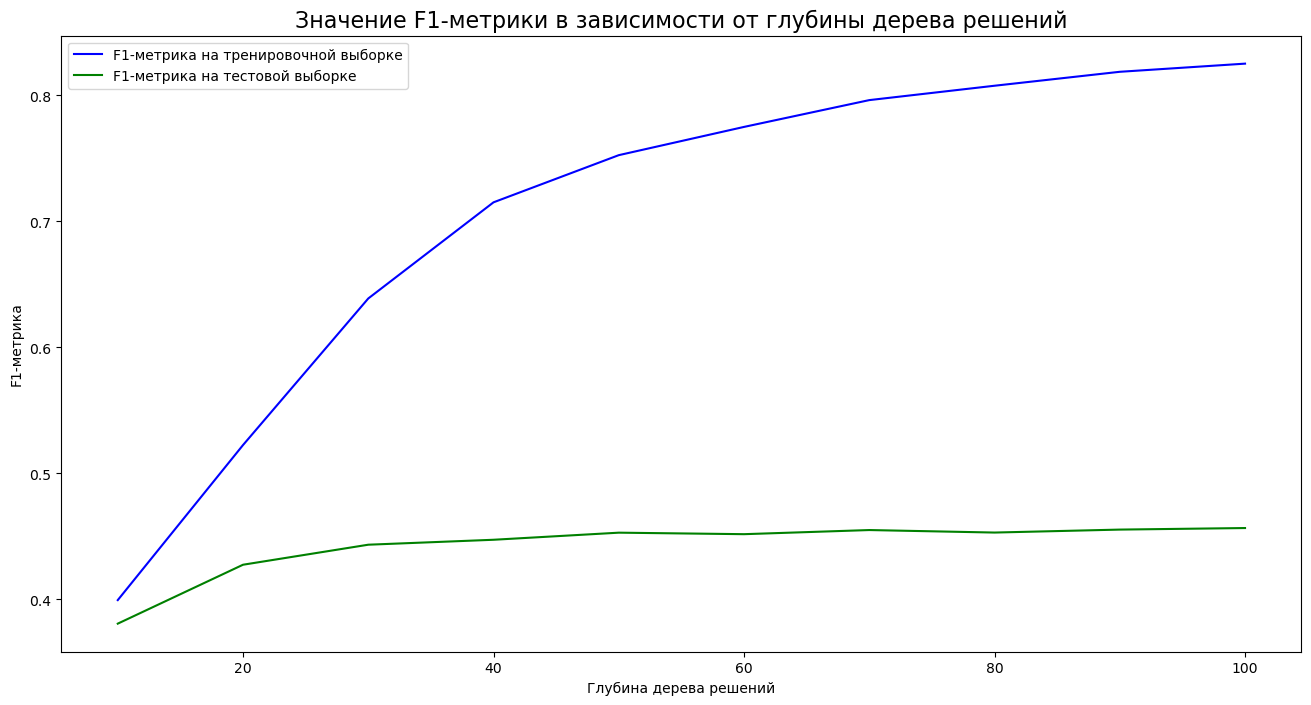

In [10]:
# Подберем оптимальную глубину дерева решений.
max_depths = range(10, 105, 10)
f1_train = []
f1_test = []

for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        class_weight='balanced',
        random_state=42
    )
    dt.fit(X_train, y_train)
    y_train_pred_dt = dt.predict(X_train)
    y_test_pred_dt = dt.predict(X_test)
    f1_train.append(f1_score(y_train, y_train_pred_dt, average='macro'))
    f1_test.append(f1_score(y_test, y_test_pred_dt, average='macro'))
    
# Построим линейный графики изменения F1-метрики в зависимости от значения параметра глубины дерева решений
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(
    list(max_depths),
    f1_train,
    color='blue',
    label='F1-метрика на тренировочной выборке'
)

ax.plot(
    list(max_depths),
    f1_test,
    color='green',
    label='F1-метрика на тестовой выборке'
)
    
ax.set_title('Значение F1-метрики в зависимости от глубины дерева решений', fontsize=16)
ax.set_xlabel('Глубина дерева решений')
ax.set_ylabel('F1-метрика')
ax.legend();

На основании построенного графика видим, что максимальное значение F1-метрики достигается при значении глубины дерева решений 30, после указанного значения глубины дерева решений наблюдается только прирост F1-метрики на обучающей выборке, при этом изменения метрики качества на тестовой выборке не наблюдается, то есть модель переобучается. Таким образом для исключения возможности переобучения модели, ограничим глубину дерева решений значением равным 30.

In [11]:
# Создадим объект класса решающее дерево.
dtr_lim = tree.DecisionTreeClassifier( 
    max_depth=30,
    class_weight='balanced',
    random_state=42
)

# Обучаем модель.
dtr_lim.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_dtr_lim = dtr_lim.predict(X_test)
y_train_pred_dtr_lim = dtr_lim.predict(X_train)

print('F1 решающие деревья (train):', f1_score(y_train, y_train_pred_dtr_lim, average='macro').round(3))
print('F1 решающие деревья (test):', f1_score(y_test, y_test_pred_dtr_lim, average='macro').round(3))

F1 решающие деревья (train): 0.639
F1 решающие деревья (test): 0.443


Построим модель классификации на основании алгоритма k ближайших соседей с параметрами по умолчанию.

In [12]:
# Создадим объект класса.
kn_cls = neighbors.KNeighborsClassifier(n_jobs = -1)

# Обучаем модель.
kn_cls.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_kn_cls = kn_cls.predict(X_test)
y_train_pred_kn_cls = kn_cls.predict(X_train)

print('F1 k ближайших соседей (train):', f1_score(y_train, y_train_pred_kn_cls, average='macro').round(3))
print('F1 k ближайших соседей (test):', f1_score(y_test, y_test_pred_kn_cls, average='macro').round(3))

F1 k ближайших соседей (train): 0.553
F1 k ближайших соседей (test): 0.431


На основании результатов обучения выбранных алгоритмов классификации, видим, что наилучшие результаты показали решающие деревья. Для улучшения качества модели, произведем поиск гиперпараметров с помощью GridSearchCV.

In [13]:
# Задаем сетку параметров.
param_grid = {
    'criterion': ['gini','entropy'],
    'min_samples_leaf': range(1, 11),
    'min_samples_split': range(2, 10, 2),
    'ccp_alpha': [0.0, 0.001, 0.01]
}

# Создадим объект класса GridSearchCV. 
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        max_depth=30,
        class_weight='balanced', 
        random_state=42
        ), 
    param_grid=param_grid, 
    scoring='f1_macro',
    cv=5, 
    n_jobs = -1
) 

# Обучаем модель с наилучшими значениями гиперпараметров.
grid_search.fit(X_train, y_train)

y_train_pred_gs = grid_search.predict(X_train)
y_test_pred_gs = grid_search.predict(X_test)

print('F1-метрика на обучающей выборке:', f1_score(y_train, y_train_pred_gs, average='macro').round(3))
print('F1-метрика на тестовой выборке:', f1_score(y_test, y_test_pred_gs, average='macro').round(3))
print('Наилучшие значения гиперпараметров:', grid_search.best_params_)

F1-метрика на обучающей выборке: 0.596
F1-метрика на тестовой выборке: 0.45
Наилучшие значения гиперпараметров: {'ccp_alpha': 0.0, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 8}


В результате подбора гиперпараметров удалось улучшить метрику качества на 0,007. Для улчшения модели будем использовать ансамблевые алгоритмы. 

### Бэггинг

In [14]:
# Создадим объект класса случайный лес, в качестве гиперпараметров передадим 
# значения, полученные с помощью GridSearchCV.
rf_cls = ensemble.RandomForestClassifier(
    max_depth=30,
    min_samples_split=8,
    class_weight='balanced', 
    random_state=42
)

# Обучаем модель
rf_cls.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_rf_cls = rf_cls.predict(X_test)
y_train_pred_rf_cls = rf_cls.predict(X_train)

print('F1 случайный лес (train):', f1_score(y_train, y_train_pred_rf_cls, average='macro').round(3))
print('F1 случайный лес (test):', f1_score(y_test, y_test_pred_rf_cls, average='macro').round(3))

F1 случайный лес (train): 0.582
F1 случайный лес (test): 0.488


In [15]:
# Выведем ТОП-20 признаков по значимости.
feature_importances = (
    pd.Series(rf_cls.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
    .head(20)
)
feature_importances

ngo_age                                                                                                                                             0.080292
Предоставление социальных услуг без обеспечения проживания престарелым и инвалидам                                                                  0.031350
regionName_Москва                                                                                                                                   0.028037
Деятельность по дополнительному профессиональному образованию прочая, не включенная в другие группировки                                            0.020378
Подготовка кадров высшей квалификации                                                                                                               0.019955
Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе                                                                  0.018585
Научные исследования и разработки в области общественных и

Из полученных данных, видим, что нам удалось улучшуть метрику качества предсказательной модели. При этомнаиболее значимым признаком является возраст НКО. На 3 и 19 позициях значатся признаки, соответствующие расположению НКО в Москве и Санкт-Петербурге соответственно. На остальных позициях значатся признаки, соответствующие определенному виду экономической деятельности.

### Бустинг

In [16]:
# Реализуем алгоритм адаптивного бустинга.
# В качестве базовой модели будем использовать решющие деревья.
base_estimator= tree.DecisionTreeClassifier( 
    max_depth=30,
    class_weight='balanced',
    random_state=42
)

# Создадим объект класса AdaBoostClassifier.
ada_cls = ensemble.AdaBoostClassifier(
    base_estimator=base_estimator,
    learning_rate=0.0001,
    random_state=42, 
    n_estimators=50
)

# Обучаем модель
ada_cls.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_ada_cls = ada_cls.predict(X_test)
y_train_pred_ada_cls = ada_cls.predict(X_train)

print('F1 адаптивный бустинг (train):', f1_score(y_train, y_train_pred_ada_cls, average='macro').round(3))
print('F1 адаптивный бустинг (test):', f1_score(y_test, y_test_pred_ada_cls, average='macro').round(3))

F1 адаптивный бустинг (train): 0.685
F1 адаптивный бустинг (test): 0.448


### Стекинг

In [17]:
# Создаем список кортежей базовых моделей.
estimators = [
    ('lr', linear_model.LogisticRegression(
        multi_class='multinomial', 
        class_weight='balanced',
        random_state=42
        )
    ),
    ('dt', tree.DecisionTreeClassifier( 
        max_depth=30,
        class_weight='balanced',
        random_state=42
        )
    ),
    ('kn', neighbors.KNeighborsClassifier(n_jobs = -1))
]

# Создаем объект класса стекинг.
st_cls = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(
        max_depth=100,
        class_weight='balanced', 
        random_state=42
    ),
    cv=5,
    n_jobs=-1
)

#Обучаем модель
st_cls.fit(X_train, y_train)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_st_cls = st_cls.predict(X_test)
y_train_pred_st_cls = st_cls.predict(X_train)

print('F1 стекинг (train):', f1_score(y_train, y_train_pred_st_cls, average='macro').round(3))
print('F1 стекинг (test):', f1_score(y_test, y_test_pred_st_cls, average='macro').round(3))

F1 стекинг (train): 0.537
F1 стекинг (test): 0.554


На основании метрики качества построенных алгоритмов классификации, видим, что наилучший результат продемострировал классификатор на основании стекинга, значение метрики качества более чем в 2,5 раза превышает случайное угадывание. Для обеспечения возможности интерпритации построенного прогноза рассчитаем метрики Precision и Recall на тестовой выборке. 

In [18]:
print('Precision тестовая выборка:', precision_score(y_test, y_test_pred_st_cls, average='macro').round(3))
print('Recall тестовая выборка:', recall_score(y_test, y_test_pred_st_cls, average='macro').round(3))

Precision тестовая выборка: 0.647
Recall тестовая выборка: 0.515


**Вывод:** расчет метрик классификации Precision и Recall позволяет рассчитать полную вероятность, того что модель может кореектно определить класс объекта, в нашем случае она составляет 0,647 * 0,515 = 0,333. То есть только в 1 из 3 случаев модель корректно определяет принадлежность объекта определенному классу (получала ли НКО грант / заклучала госконтракт).

Построим упрощенный вариант модели для случая бинарной классификации, для отого объеденим классы 1, 2 и 3 в один класс, то есть мы будем отслеживать лишь возможность получения гранта или заклучения госконтракта независимо от вида господдержки). В качестве модели классификации будем использовать алгоритм стекинга. 

In [19]:
# Оьъеденим классы в обучающей и тестовой выборках.
y_train_bin = y_train['has_grant_contract'].apply(lambda x: 1 if x in [2, 3] else x)
y_test_bin = y_test['has_grant_contract'].apply(lambda x: 1 if x in [2, 3] else x)

# Создаем список кортежей базовых моделей.
estimators_bin = [
    ('lr', linear_model.LogisticRegression(random_state=42)),
    ('dt', tree.DecisionTreeClassifier(random_state=42)),
    ('kn', neighbors.KNeighborsClassifier(n_jobs = -1))
]

# Создаем объект класса стекинг.
st_cls_bin = ensemble.StackingClassifier(
    estimators=estimators_bin,
    final_estimator=ensemble.RandomForestClassifier(
        max_depth=100,
        random_state=42
    ),
    cv=5,
    n_jobs=-1
)

#Обучаем модель
st_cls_bin.fit(X_train, y_train_bin)

# Предсказание класса для обучающей и тестовой выборок.
y_test_pred_st_cls_bin = st_cls_bin.predict(X_test)
y_train_pred_st_cls_bin = st_cls_bin.predict(X_train)

print('F1 бинарный стекинг (train):', f1_score(y_train_bin, y_train_pred_st_cls_bin).round(3))
print('F1 бинарный стекинг (test):', f1_score(y_test_bin, y_test_pred_st_cls_bin).round(3))

F1 бинарный стекинг (train): 0.742
F1 бинарный стекинг (test): 0.662


In [20]:
print('Precision тестовая выборка:', precision_score(y_test_bin, y_test_pred_st_cls_bin).round(3))
print('Recall тестовая выборка:', recall_score(y_test_bin, y_test_pred_st_cls_bin).round(3))

Precision тестовая выборка: 0.661
Recall тестовая выборка: 0.663


Произведем расчет метрик классификации Precision и Recall для бинарного случая и рассчитаем полную вероятность, того что модель может кореектно определить класс объекта, в нашем случае она составляет 0.663 * 0.661 = 0,438.

In [21]:
# Подготовим полученные модели для реализации в ПРОД, для этого
# произведем сериализацию и запись результатов в файлы формата pkl.
with open('stacking_multi.pkl', 'wb') as output:
    pickle.dump(st_cls, output)

with open('stacking_bin.pkl', 'wb') as output:
    pickle.dump(st_cls_bin, output)

# Вывод

На основании полученных данных мы можем сделать вывод о том, что зависимость получения гранта / заключекния госконтракта от признаков: возраст НКО, месторасположение и видов эконимеческой деятельности есть, но данная зависимость слабая. Наиболее важным признаком в данном случае является возраст НКО.